# Importing Libraries

In [1]:
from pydantic import BaseModel
from langgraph.graph import END, START, StateGraph

# Pydantic Model

In [2]:
class Person(BaseModel):
    name: str
    age: int

# Logic to modify state

In [3]:
def modify_state(person: Person):
    print(f"Current Value: {person}")
    person.name = "Dr. " + person.name
    return person


# Building Graph

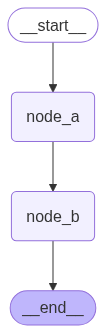

In [4]:
graph = StateGraph(Person)

graph.add_node("node_a", modify_state)
graph.add_node("node_b", modify_state)
graph.add_edge(START, "node_a")
graph.add_edge("node_a", "node_b")
graph.add_edge("node_b", END)

graph.set_entry_point("node_a")

runnable = graph.compile()
runnable

# Visualize Graph

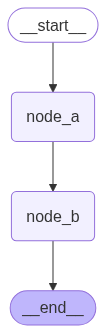

In [5]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [6]:
runnable.invoke({"name": "SSH", "age": "45"})

Current Value: name='SSH' age=45
Current Value: name='Dr. SSH' age=45


{'name': 'Dr. Dr. SSH', 'age': 45}

In [7]:
runnable.invoke({"name": "SSH", "age": "30"})

Current Value: name='SSH' age=30
Current Value: name='Dr. SSH' age=30


{'name': 'Dr. Dr. SSH', 'age': 30}

In [8]:
runnable.invoke({"name": "BCc"})

ValidationError: 1 validation error for Person
age
  Field required [type=missing, input_value={'name': 'BCc'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

# Cycles and conditional edges

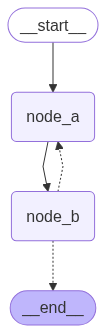

In [ ]:
class Person2(BaseModel):
    name: str
    age: int
    counter: int


def modify_state(person: Person2):
    print(f"Current Value: {person}")
    person.name = "Dr. " + person.name
    person.counter += 1
    return person

def router(person: Person2):
    if person.counter < 5 and person.age < 45: 
        return "node_a"
    else:
        return "__end__"


graph = StateGraph(Person2)

graph.add_node("node_a", modify_state)
graph.add_node("node_b", modify_state)

graph.add_edge("node_a", "node_b")

graph.add_conditional_edges(
    "node_b", router, {
        "node_a": "node_a", "__end__": END
    }
)

graph.set_entry_point("node_a")
runnable_conditional = graph.compile()
runnable_conditional

In [ ]:
runnable_conditional.invoke({"name": "SSH", "age": 40, "counter": 1})

Current Value: name='SSH' age=40 counter=1
Current Value: name='Dr. SSH' age=40 counter=2
Current Value: name='Dr. Dr. SSH' age=40 counter=3
Current Value: name='Dr. Dr. Dr. SSH' age=40 counter=4


{'name': 'Dr. Dr. Dr. Dr. SSH', 'age': 40, 'counter': 5}

In [ ]:
runnable_conditional.invoke({"name": "SSH", "age": 50, "counter": 1})

Current Value: name='SSH' age=50 counter=1
Current Value: name='Dr. SSH' age=50 counter=2


{'name': 'Dr. Dr. SSH', 'age': 50, 'counter': 3}

In [ ]:
runnable_conditional.invoke({"name": "SSH", "age": 55, "counter": 1})

Current Value: name='SSH' age=55 counter=1
Current Value: name='Dr. SSH' age=55 counter=2


{'name': 'Dr. Dr. SSH', 'age': 55, 'counter': 3}

# Reducer Function

### Annotated
In Python's typing module, Annotated is a special type hint introduced in Python 3.9 that allows you to attach arbitrary metadata to a type. This metadata is ignored by static type checkers but can be accessed at runtime for various purposes, such as validation, documentation, or custom behaviors in libraries like FastAPI or Pydantic. 

In [ ]:
from typing import Annotated
from langgraph.graph import START, END, StateGraph
from operator import add
from pydantic import BaseModel

class Person3(BaseModel):
    no_change_name: str
    name: Annotated[str, add]
    age: Annotated[int, add]
    counter: Annotated[int, add]
    about: Annotated[list[str], add]


def alter_state(person: Person3):
    return person

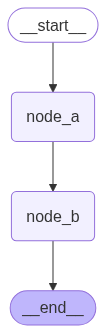

In [ ]:
graph = StateGraph(Person3)

graph.add_node("node_a", alter_state)
graph.add_node("node_b", alter_state)

graph.add_edge("node_a", "node_b")
graph.add_edge("node_b", END)

graph.set_entry_point("node_a")

graph_builder = graph.compile()
graph_builder

In [ ]:
graph_builder.invoke({
    "no_change_name": "SSH",
    "name": "SSH",
    "age": 26,
    "counter": 1,
    "about": ["...."]
})

{'no_change_name': 'SSH',
 'name': 'SSHSSHSSHSSH',
 'age': 104,
 'counter': 4,
 'about': ['....', '....', '....', '....']}